In [17]:
import torch
import numpy as np
from collections import deque

In [18]:
def rosenbrock(x):
    a = 1
    b = 100
    return (a - x[0])**2 + b*(x[1] - x[0]**2)**2

def rastrigin(x):
    A = 10
    n = x.size()[0]
    return A*n + torch.sum(x**2 - A*torch.cos(2*torch.pi*x))

In [31]:
x = np.full(5, 1.0)
x = torch.tensor(x, requires_grad=True)
optimizer = torch.optim.SGD([x], lr=0.01)
sgd_loss = []
for i in range(100):
    optimizer.zero_grad()
    y = rastrigin(x)
    if (i+1)%10 == 0:
        print(x.detach().numpy(),y.item())
    sgd_loss.append(y.item())
    y.backward()
    optimizer.step()

[0.80851355 0.80851355 0.80851355 0.80851355 0.80851355] 35.29722884530693
[1.33004517 1.33004517 1.33004517 1.33004517 1.33004517] 82.94521985109407
[1.18909291 1.18909291 1.18909291 1.18909291 1.18909291] 38.39882308444702
[0.86557965 0.86557965 0.86557965 0.86557965 0.86557965] 20.544170746676897
[0.59516125 0.59516125 0.59516125 0.59516125 0.59516125] 93.0966176176289
[0.69405632 0.69405632 0.69405632 0.69405632 0.69405632] 69.6241074507475
[0.58373702 0.58373702 0.58373702 0.58373702 0.58373702] 94.94146502141554
[1.25042987 1.25042987 1.25042987 1.25042987 1.25042987] 57.95292312741144
[0.77737947 0.77737947 0.77737947 0.77737947 0.77737947] 44.462443284581006
[0.90368389 0.90368389 0.90368389 0.90368389 0.90368389] 12.96300915550708


In [48]:
x = np.full(5, 1.0)
x = torch.tensor(x, requires_grad=True)
optimizer = torch.optim.LBFGS([x], lr=1, line_search_fn=None)
lbgfs_loss = []
def closure():
    optimizer.zero_grad()
    y = rastrigin(x)
    y.backward()
    lbgfs_loss.append(y.item())
    return y
for i in range(50):
    optimizer.step(closure)
    print(x.detach().numpy(),rastrigin(x).item())

[0.99495855 0.99495855 0.99495855 0.99495855 0.99495855] 4.974795285474727
[0.99495855 0.99495855 0.99495855 0.99495855 0.99495855] 4.974795285474727
[0.99495855 0.99495855 0.99495855 0.99495855 0.99495855] 4.974795285474727
[0.99495855 0.99495855 0.99495855 0.99495855 0.99495855] 4.974795285474727
[0.99495855 0.99495855 0.99495855 0.99495855 0.99495855] 4.974795285474727
[0.99495855 0.99495855 0.99495855 0.99495855 0.99495855] 4.974795285474727
[0.99495855 0.99495855 0.99495855 0.99495855 0.99495855] 4.974795285474727
[0.99495855 0.99495855 0.99495855 0.99495855 0.99495855] 4.974795285474727
[0.99495855 0.99495855 0.99495855 0.99495855 0.99495855] 4.974795285474727
[0.99495855 0.99495855 0.99495855 0.99495855 0.99495855] 4.974795285474727
[0.99495855 0.99495855 0.99495855 0.99495855 0.99495855] 4.974795285474727
[0.99495855 0.99495855 0.99495855 0.99495855 0.99495855] 4.974795285474727
[0.99495855 0.99495855 0.99495855 0.99495855 0.99495855] 4.974795285474727
[0.99495855 0.99495855 0.

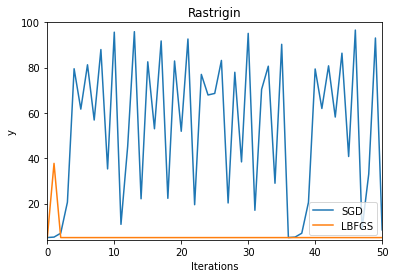

In [55]:
import matplotlib.pyplot as plt

plt.plot(sgd_loss, label='SGD')
plt.plot(lbgfs_loss, label='LBFGS')
plt.legend()
plt.ylim(4,100)
plt.xlim(0, 50)
plt.title('Rastrigin')
plt.xlabel('Iterations')
plt.ylabel('y')

plt.savefig('Rastrigin-opt.png', dpi=300)
plt.show()

In [43]:
class LBFGS():
    def __init__(self, params, lr = 0.01 , max_iter=100, memory_size=10, line_search_fn=None):
        self.max_iter = max_iter
        self.memory_size = memory_size
        self.line_search_fn = line_search_fn
        self.s = deque(maxlen=memory_size)
        self.y = deque(maxlen=memory_size)
        self.rho = deque(maxlen=memory_size)
        self._params = list(params)
        self.last_s = None
        self.last_grad = None
        self.lr = lr
    
    def update_memory(self, s, y):
        ys = torch.dot(y, s)
        if ys > 1e-10:
            self.s.append(s)
            self.y.append(y)
            self.rho.append(1. / ys)
    
    @torch.no_grad()
    def compute_direction(self, grad):
        y = self.y[-1]
        s = self.s[-1]
        ys = torch.dot(y, s)
        q = grad.clone()
        alpha = []
        for s, y, rho in zip(reversed(self.s), reversed(self.y), reversed(self.rho)):
            alpha_i = rho * torch.dot(s, q)
            q.add_(y, alpha=-alpha_i)
            alpha.append(alpha_i)

        H_diag = ys / y.dot(y)
        r = torch.mul(q, H_diag)
        for s, y, rho, alpha_i in zip(self.s, self.y, self.rho, reversed(alpha)):
            beta = rho * torch.dot(y, r)
            r.add_(s, alpha=alpha_i - beta)
        return -r
    
    def zero_grad(self):
        for p in self._params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

    def _gather_flat_grad(self):
        views = []
        for p in self._params:
            if p.grad is None:
                view = p.new(p.numel()).zero_()
            elif p.grad.is_sparse:
                view = p.grad.to_dense().view(-1)
            else:
                view = p.grad.view(-1)
            views.append(view)
        return torch.cat(views, 0)
    
    def _add_grad(self, step_size, update):
        offset = 0
        for p in self._params:
            numel = p.numel()
            # view as to avoid deprecated pointwise semantics
            p.add_(update[offset:offset + numel].view_as(p), alpha=step_size)
            offset += numel
        assert offset == self._gather_flat_grad().numel()

    @torch.no_grad()
    def step(self, closure = None):
        loss = None
        if closure is not None:
            closure = torch.enable_grad()(closure)
            loss = closure()
            loss = loss.item()
        grad = self._gather_flat_grad()
        if grad is None:
            raise ValueError("Function passed to LBFGS.step() must compute gradients.")
        if self.last_grad is not None and self.last_s is not None:
            self.update_memory(self.last_s, grad - self.last_grad)
            self.last_grad = None
            self.last_s = None
        if len(self.s) > 0:
            p = self.compute_direction(grad)
        else:
            p = -grad
        alpha = self.lr
        s = alpha * p
        self._add_grad(alpha, p)
        
        self.last_s = s
        self.last_grad = grad.clone()

        return loss

In [44]:
x = torch.zeros(2, requires_grad=True)
optimizer = LBFGS([x], lr=0.1, line_search_fn=None)
def closure():
    optimizer.zero_grad()
    y = rosenbrock(x)
    y.backward()
    return y
for i in range(20):
    optimizer.step(closure)
    print(x.detach().numpy(),rosenbrock(x).item())

[0.2 0. ] 0.8000000715255737
[0.20035112 0.004158  ] 0.7689127922058105
[0.20987187 0.01156613] 0.7297979593276978
[0.21954417 0.01878273] 0.6956467628479004
[0.23001076 0.02621732] 0.6641064286231995
[0.24125864 0.03393696] 0.6345858573913574
[0.2532881  0.04202444] 0.6065542101860046
[0.26607516 0.05055515] 0.5796148180961609
[0.27958122 0.05959861] 0.5534768104553223
[0.29376218 0.06921907] 0.527934730052948
[0.3085756  0.07947586] 0.5028520226478577
[0.32428503 0.09046173] 0.478196918964386
[0.34045222 0.10214499] 0.4539445638656616
[0.3567635  0.11453556] 0.4299958348274231
[0.37343296 0.12765478] 0.4065040647983551
[0.39040458 0.1415908 ] 0.3833245038986206
[0.40827233 0.15646686] 0.3605853319168091
[0.4244125  0.17251627] 0.33709171414375305
[0.50296265 0.22864918] 0.30620333552360535
[0.5999832 0.3387388] 0.20513172447681427


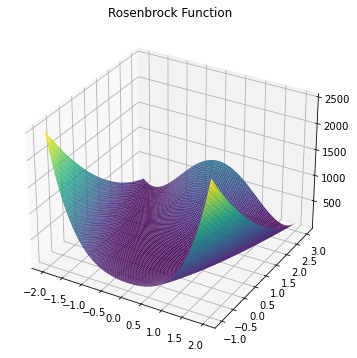

<Figure size 432x288 with 0 Axes>

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def rosenbrock(x, y, a=1, b=100):
    return (a - x)**2 + b*(y - x**2)**2

x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 3, 100)
x, y = np.meshgrid(x, y)
z = rosenbrock(x, y)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Rosenbrock Function')
plt.savefig('fig-Rosenbrock-func.png', dpi=300)
plt.show()


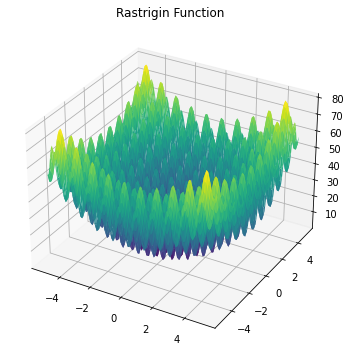

<Figure size 432x288 with 0 Axes>

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def rastrigin(x, A=10):
    n = len(x)
    return A*n + sum([(xi**2 - A*np.cos(2*np.pi*xi)) for xi in x])

x = np.linspace(-5.12, 5.12, 100)
y = np.linspace(-5.12, 5.12, 100)
x, y = np.meshgrid(x, y)
z = rastrigin([x, y])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Rastrigin Function')
plt.show()
plt.savefig('fig-Rastrigin-func.png', dpi=300)
